In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
import os

# Преобразование изображений

## Гомография

In [2]:
def normalize(points):
    '''нормировать коллекцию точек в однородных координатах, чтобы последняя строка была 1'''

    for row in points:
        row /= points[-1]
    return points

In [ ]:
def make_homog(points):
    '''преобразовать множество точек (массив dim*n) в однородные координаты'''

    return np.vstack(points, np.ones((1, points.shape[-1])))

In [4]:
def H_from_points(fp,tp):
    """ найти гомографию H (достаточно четырех точек), отображающую точки
     fp в tp с использованием метода DLT """
    
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # condition points (important for numerical reasons)
    # --from points--
    m = np.mean(fp[:2], axis=1)
    maxstd = np.max(np.std(fp[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1]) 
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp = np.dot(C1,fp)
    
    # --to points--
    m = np.mean(tp[:2], axis=1)
    maxstd = np.max(np.std(tp[:2], axis=1)) + 1e-9
    C2 = np.diag([1/maxstd, 1/maxstd, 1])
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp = np.dot(C2,tp)
    
    # create matrix for linear method, 2 rows for each correspondence pair
    nbr_correspondences = fp.shape[1]
    A = np.zeros((2*nbr_correspondences,9))
    for i in range(nbr_correspondences):        
        A[2*i] = [-fp[0][i],-fp[1][i],-1,0,0,0,
                    tp[0][i]*fp[0][i],tp[0][i]*fp[1][i],tp[0][i]]
        A[2*i+1] = [0,0,0,-fp[0][i],-fp[1][i],-1,
                    tp[1][i]*fp[0][i],tp[1][i]*fp[1][i],tp[1][i]]
    
    U,S,V = np.linalg.svd(A)
    H = V[8].reshape((3,3))    
    
    # decondition
    H = np.dot(np.linalg.inv(C2),np.dot(H,C1))
    
    # normalize and return
    return H / H[2,2]

In [5]:
def Haffine_from_points(fp,tp):
    """ найти афинную гомографию H (достаточно трех точек), отображающую точки
     fp в tp с использованием метода DLT """
    
    if fp.shape != tp.shape:
        raise RuntimeError('number of points do not match')
        
    # condition points
    # --from points--
    m = np.mean(fp[:2], axis=1)
    maxstd = np.max(snp.td(fp[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1]) 
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = np.dot(C1,fp)
    
    # --to points--
    m = np.mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = np.dot(C2,tp)
    
    # conditioned points have mean zero, so translation is zero
    A = np.concatenate((fp_cond[:2],tp_cond[:2]), axis=0)
    U,S,V = np.linalg.svd(A.T)
    
    # create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]
    
    tmp2 = np.concatenate((dot(C,np.linalg.pinv(B)),np.zeros((2,1))), axis=1) 
    H = np.vstack((tmp2,[0,0,1]))
    
    # decondition
    H = np.dot(np.linalg.inv(C2),np.dot(H,C1))
    
    return H / H[2,2]

### Деформирование изображений

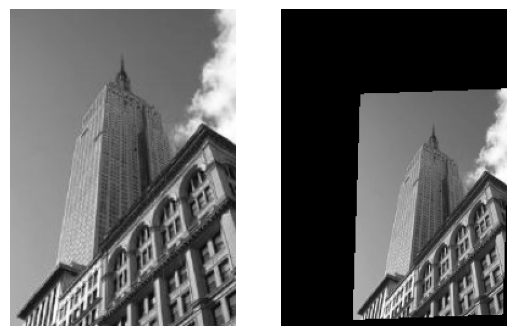

In [ ]:
im = np.array(Image.open('pic.jpg').convert('L'))
H = np.array([[1.4, 0.05, -100], [0.05, 1.5, -100], [0, 0, 1]])
im2 = ndimage.affine_transform(im, H[:2, :2], (H[0, 2], H[1, 2]))

fig, axs = plt.subplots(1, 2)
for ax in axs.ravel():
    ax.set_axis_off()
plt.gray()
axs[0].imshow(im)
axs[1].imshow(im2)
plt.show()

### Изображение внутри изображения

In [11]:
from PCV.geometry import *

In [12]:
def image_in_image(im1,im2,tp):
    """ Put im1 in im2 with an affine transformation
        such that corners are as close to tp as possible.
        tp are homogeneous and counter-clockwise from top left. """ 
    
    # points to warp from
    m,n = im1.shape[:2]
    fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])
    
    # compute affine transform and apply
    H = Haffine_from_points(tp,fp)
    im1_t = ndimage.affine_transform(im1,H[:2,:2],
                    (H[0,2],H[1,2]),im2.shape[:2])
    alpha = (im1_t > 0)
    
    return (1-alpha)*im2 + alpha*im1_t

### Кусочно-афинное преобразование

С помощью аффинного деформирования частей изображения можно точно совместить угловые точки. Рассмотрим наиболее употребительную форму деформирования при заданном множестве пар соответственных точек — кусочно-аффинное деформирование. Произвольное изображение с опорными точками можно деформировать в другое изображение с соответствен-
ными опорными точками, если выполнить триангуляцию исходного изображения по опорным точкам, а затем произвести аффинное преобразование каждого треугольника. В любой графической библиотеке существуют стандартные средства для выполнения этой операции. Ниже показано, как это сделать с помощью Маtplotlib i SciPy.

Часто применяется триангуляция Делоне. Ее реализация имеется в библиотеке Маtplotlib и воспользоваться ей
можно так:

In [18]:
from matplotlib.tri import Triangulation

Text(0.5, 1.0, 'triplot of Delaunay triangulation')

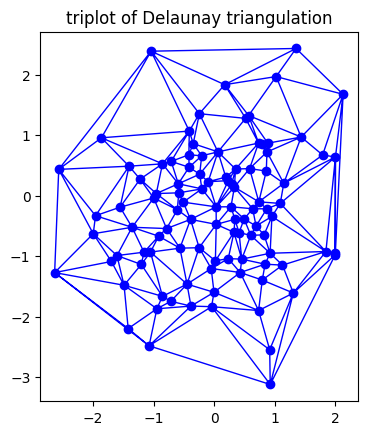

In [22]:
x, y = np.array(np.random.standard_normal((2, 100)))
tri = Triangulation(x, y)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(tri, 'bo-', lw=1)
ax1.set_title('triplot of Delaunay triangulation')

In [23]:
tri.triangles

array([[ 2, 51, 97],
       [ 9, 44, 87],
       [ 0, 97, 91],
       [21, 58, 47],
       [79, 71, 63],
       [63, 45, 79],
       [ 7, 71, 79],
       [79, 45,  7],
       [ 7, 45, 12],
       [84, 21, 47],
       [84, 39, 75],
       [91, 97, 56],
       [44,  9, 15],
       [20, 51,  2],
       [87, 51, 20],
       [20, 52, 87],
       [50,  9, 11],
       [11, 52, 50],
       [11,  9, 87],
       [87, 52, 11],
       [76,  0, 91],
       [ 2, 97, 99],
       [97,  0, 99],
       [47, 58, 90],
       [ 7, 12, 90],
       [90, 56,  7],
       [58, 56, 90],
       [10, 25, 24],
       [80, 44, 24],
       [24, 25, 80],
       [41, 25, 10],
       [41, 71, 80],
       [80, 25, 41],
       [47, 13, 92],
       [92, 84, 47],
       [39, 84, 92],
       [92, 94, 39],
       [ 8, 92, 13],
       [94, 92,  8],
       [82, 13, 47],
       [64,  9, 50],
       [33, 46, 30],
       [30, 46, 89],
       [50, 52, 89],
       [52, 27, 89],
       [96, 76, 91],
       [91, 56, 96],
       [58, 2

In [24]:
def pw_affine(fromim,toim,fp,tp,tri):
    """ Warp triangular patches from an image.
        fromim = image to warp 
        toim = destination image
        fp = from points in hom. coordinates
        tp = to points in hom.  coordinates
        tri = triangulation. """
                
    im = toim.copy()
    
    # check if image is grayscale or color
    is_color = len(fromim.shape) == 3
    
    # create image to warp to (needed if iterate colors)
    im_t = np.zeros(im.shape, 'uint8') 
    
    for t in tri:
        # compute affine transformation
        H = homography.Haffine_from_points(tp[:,t],fp[:,t])
        
        if is_color:
            for col in range(fromim.shape[2]):
                im_t[:,:,col] = ndimage.affine_transform(
                    fromim[:,:,col],H[:2,:2],(H[0,2],H[1,2]),im.shape[:2])
        else:
            im_t = ndimage.affine_transform(
                    fromim,H[:2,:2],(H[0,2],H[1,2]),im.shape[:2])
        
        # alpha for triangle
        alpha = alpha_for_triangle(tp[:,t],im.shape[0],im.shape[1])
        
        # add triangle to image
        im[alpha>0] = im_t[alpha>0]
        
    return im

In [ ]:
from PCV.geometry import homography, warp

# открыть деформируемое изображение
fromim = np.array(Image.open('pic.jpg'))
x, y = np.meshgrid(range(5), range(6))
x = (fromim.shape[1]/4) * x.flatten()
y = (fromim.shape[1]/4) * y.flatten()

# триангулировать
tri = warp.triangulate_points(x, y)

# открыть конечное изображение и файл конечных точек
im = np.array(Image.open('pic2.jpg'))
tp = np.loadtxt('filename') # конечные точки

# преобразовать точки к однородным координатам
fp = np.vstack((y, x, np.ones((1, len(x)))))
tp = np.vstack((tp[:,1], tp[:, 0], np.ones(1, len(tp))))

# деформировать треугольники
im = warp.pw_affine(fromim, im, fp, tp, tri)

plt.figure()
plt.imshow(im)
warp.plot_mesh(tp[1], tp[0], tri)
plt.axis('off')
plt.show

Через scipy

In [14]:
from scipy.spatial import Delaunay
points = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
tri = Delaunay(points)

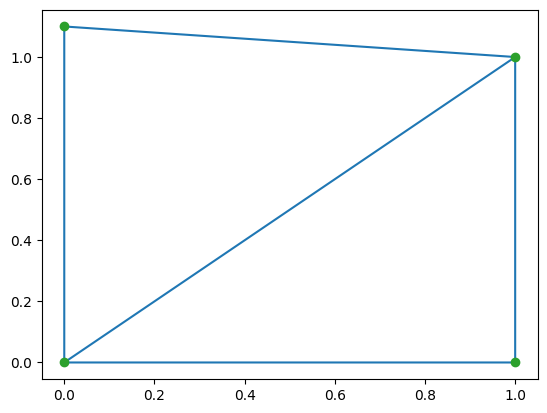

In [15]:
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [16]:
# Point indices and coordinates for the two triangles forming the triangulation:
tri.simplices

array([[2, 3, 0],
       [3, 1, 0]], dtype=int32)

In [17]:
points[tri.simplices]

array([[[1. , 0. ],
        [1. , 1. ],
        [0. , 0. ]],

       [[1. , 1. ],
        [0. , 1.1],
        [0. , 0. ]]])

## Гомография openCV

In [ ]:
import cv2
import numpy as np
 
if __name__ == '__main__' :
 
    # Read source image.
    im_src = cv2.imread('book2.jpg')
    # Four corners of the book in source image
    pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]])
 
    # Read destination image.
    im_dst = cv2.imread('book1.jpg')
    # Four corners of the book in destination image.
    pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]])
 
    # Calculate Homography
    h, status = cv2.findHomography(pts_src, pts_dst)
 
    # Warp source image to destination based on homography
    im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
 
    # Display images
    cv2.imshow("Source Image", im_src)
    cv2.imshow("Destination Image", im_dst)
    cv2.imshow("Warped Source Image", im_out)
 
    cv2.waitKey(0)

## Регистрация изображений

Приведение изображений к единой системе координат

Пример изометрической регистрации. Вычислим среднее лицо и отклонения на примере https://www.kaggle.com/datasets/ambarish/images-of-computer-vision-book-by-jan-erik-solem?resource=download

In [34]:
from xml.dom import minidom

def read_points_from_xml(xmlFileName):
    """ Reads control points for face alignment. """

    xmldoc = minidom.parse(xmlFileName)
    facelist = xmldoc.getElementsByTagName('face')    
    faces = {}    
    for xmlFace in facelist:
        fileName = xmlFace.attributes['file'].value
        xf = int(xmlFace.attributes['xf'].value)
        yf = int(xmlFace.attributes['yf'].value)     
        xs = int(xmlFace.attributes['xs'].value)
        ys = int(xmlFace.attributes['ys'].value)
        xm = int(xmlFace.attributes['xm'].value)
        ym = int(xmlFace.attributes['ym'].value)
        faces[fileName] = np.array([xf, yf, xs, ys, xm, ym])
    return faces

In [35]:
xmlFileName = 'jkfaces/jkfaces.xml'
faces = read_points_from_xml(xmlFileName)

In [36]:
def write_points_to_xml(faces, xmlFileName):
    xmldoc = minidom.Document()
    xmlFaces = xmldoc.createElement("faces")

    keys = faces.keys()
    for k in keys:
        xmlFace = xmldoc.createElement("face")
        xmlFace.setAttribute("file", k)
        xmlFace.setAttribute("xf", "%d" % faces[k][0])    
        xmlFace.setAttribute("yf", "%d" % faces[k][1])
        xmlFace.setAttribute("xs", "%d" % faces[k][2])    
        xmlFace.setAttribute("ys", "%d" % faces[k][3])
        xmlFace.setAttribute("xm", "%d" % faces[k][4])
        xmlFace.setAttribute("ym", "%d" % faces[k][5])
        xmlFaces.appendChild(xmlFace)

    xmldoc.appendChild(xmlFaces)

    fp = open(xmlFileName, "w")
    fp.write(xmldoc.toprettyxml(encoding='utf-8'))    
    fp.close()

In [28]:
from scipy import linalg

In [45]:
def compute_rigid_transform(refpoints,points):
    """ Computes rotation, scale and translation for
        aligning points to refpoints. """
    
    A = np.array([    [points[0], -points[1], 1, 0],
                [points[1],  points[0], 0, 1],
                [points[2], -points[3], 1, 0],
                [points[3],  points[2], 0, 1],
                [points[4], -points[5], 1, 0],
                [points[5],  points[4], 0, 1]])

    y = np.array([    refpoints[0],
                refpoints[1],
                refpoints[2],
                refpoints[3],
                refpoints[4],
                refpoints[5]])
    
    # least sq solution to mimimize ||Ax - y||
    a,b,tx,ty = linalg.lstsq(A,y)[0]
    R = np.array([[a, -b], [b, a]]) # rotation matrix incl scale

    return R,tx,ty

In [62]:
def rigid_alignment(faces,path,plotflag=False):
    """    Align images rigidly and save as new images.
        path determines where the aligned images are saved
        set plotflag=True to plot the images. """
    
    # take the points in the first image as reference points
    refpoints = list(faces.values())[0]
    
    # warp each image using affine transform
    for face in faces:
        points = faces[face]
        
        R,tx,ty = compute_rigid_transform(refpoints, points)
        T = np.array([[R[1][1], R[1][0]], [R[0][1], R[0][0]]])    
        
        im = np.array(Image.open(os.path.join(path,face)))
        im2 = np.zeros(im.shape, 'uint8')
        
        # warp each color channel
        for i in range(len(im.shape)):
            im2[:,:,i] = ndimage.affine_transform(im[:,:,i],linalg.inv(T),offset=[-ty,-tx])
            
        if plotflag:
            plt.imshow(im2)
            plt.show()
            
        # crop away border and save aligned images
        h,w = im2.shape[:2]
        border = (w+h)//20
        
        # crop away border
        plt.imsave(os.path.join(path, 'alligned/'+face),im2[border:h-border,border:w-border,:])

In [63]:
points = read_points_from_xml(xmlFileName)

# зарегистрировать
rigid_alignment(points, 'jkfaces/')

## Создание панорам

### RANSAC

Метод убирает выбросы, что позволяет отсеять лишние ключевые точки. Рассмотрим пример

In [2]:
from PCV.tools import ransac

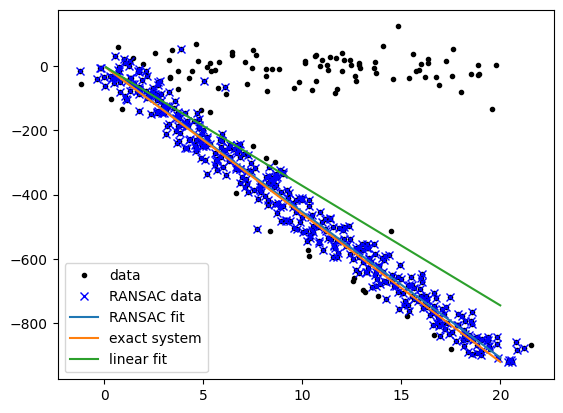

In [4]:
ransac.test()

### Устойчивое вычисление гомографии и построение панорамы

In [14]:
from PCV.local_descriptors import sift

In [ ]:
from pylab import *
from numpy import *
from PIL import Image

# If you have PCV installed, these imports should work
from PCV.geometry import homography, warp
from PCV.local_descriptors import sift

"""
This is the panorama example from section 3.3.
"""

# set paths to data folder
featname = ['../data/Univ'+str(i+1)+'.sift' for i in range(5)] 
imname = ['../data/Univ'+str(i+1)+'.jpg' for i in range(5)]

# extract features and match
l = {}
d = {}
for i in range(5): 
    sift.process_image(imname[i],featname[i])
    l[i],d[i] = sift.read_features_from_file(featname[i])

matches = {}
for i in range(4):
    matches[i] = sift.match(d[i+1],d[i])

# visualize the matches (Figure 3-11 in the book)
for i in range(4):
    im1 = array(Image.open(imname[i]))
    im2 = array(Image.open(imname[i+1]))
    figure()
    sift.plot_matches(im2,im1,l[i+1],l[i],matches[i],show_below=True)


# function to convert the matches to hom. points
def convert_points(j):
    ndx = matches[j].nonzero()[0]
    fp = homography.make_homog(l[j+1][ndx,:2].T) 
    ndx2 = [int(matches[j][i]) for i in ndx]
    tp = homography.make_homog(l[j][ndx2,:2].T) 
    
    # switch x and y - TODO this should move elsewhere
    fp = vstack([fp[1],fp[0],fp[2]])
    tp = vstack([tp[1],tp[0],tp[2]])
    return fp,tp


# estimate the homographies
model = homography.RansacModel() 

fp,tp = convert_points(1)
H_12 = homography.H_from_ransac(fp,tp,model)[0] #im 1 to 2 

fp,tp = convert_points(0)
H_01 = homography.H_from_ransac(fp,tp,model)[0] #im 0 to 1 

tp,fp = convert_points(2) #NB: reverse order
H_32 = homography.H_from_ransac(fp,tp,model)[0] #im 3 to 2 

tp,fp = convert_points(3) #NB: reverse order
H_43 = homography.H_from_ransac(fp,tp,model)[0] #im 4 to 3    


# warp the images
delta = 2000 # for padding and translation

im1 = array(Image.open(imname[1]), "uint8")
im2 = array(Image.open(imname[2]), "uint8")
im_12 = warp.panorama(H_12,im1,im2,delta,delta)

im1 = array(Image.open(imname[0]), "f")
im_02 = warp.panorama(dot(H_12,H_01),im1,im_12,delta,delta)

im1 = array(Image.open(imname[3]), "f")
im_32 = warp.panorama(H_32,im1,im_02,delta,delta)

im1 = array(Image.open(imname[4]), "f")
im_42 = warp.panorama(dot(H_32,H_43),im1,im_32,delta,2*delta)


figure()
imshow(array(im_42, "uint8"))
axis('off')
show()

### Ransac с opencv

In [20]:
import cv2
import numpy as np

In [21]:
img1 = cv2.imread('data/Univ2.jpg', 0)
img2 = cv2.imread('data/Univ3.jpg', 0)

Detect Key points and Descriptors

In [22]:
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

Match Descriptors

In [23]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

Apply RANSAC to Find Homography

In [24]:
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

### Панорама с opencv

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils

In [10]:
training_image = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
training_image_gray = cv2.cvtColor(training_image, cv2.COLOR_RGB2GRAY)

queryImage = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')

C:\Users\Алексей\AppData\Local\Temp\ipykernel_1152\2623519414.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  training_image = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1A.jpg')
C:\Users\Алексей\AppData\Local\Temp\ipykernel_1152\2623519414.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  queryImage = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto1B.jpg')


In [11]:
# Opencv defines the color channel in the order BGR. 
# Transform it to RGB to be compatible to matplotlib
queryImage_gray = cv2.cvtColor(queryImage, cv2.COLOR_RGB2GRAY)

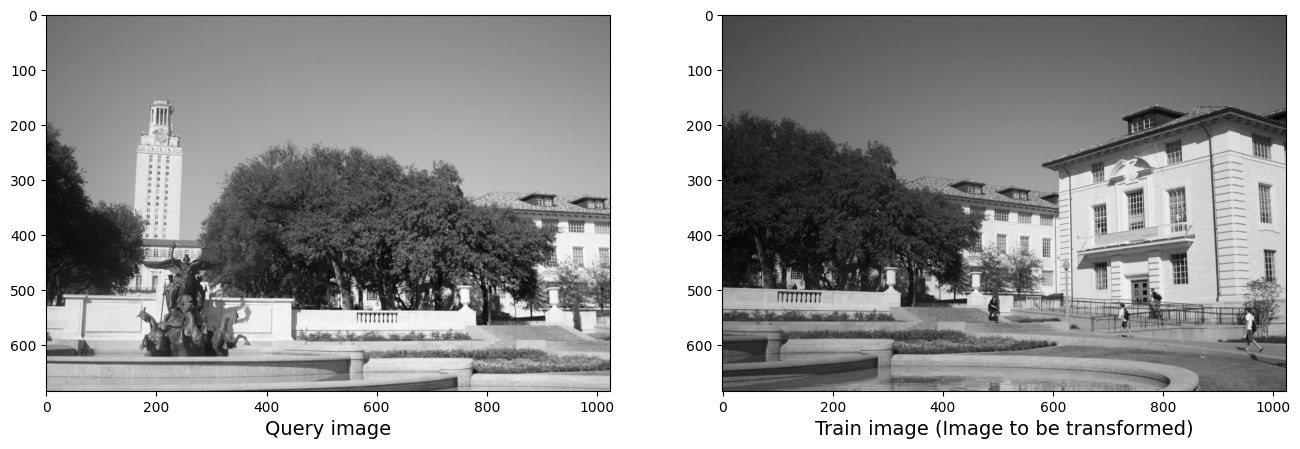

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImage_gray, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(training_image_gray, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

Keypoint Detection

In [15]:
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

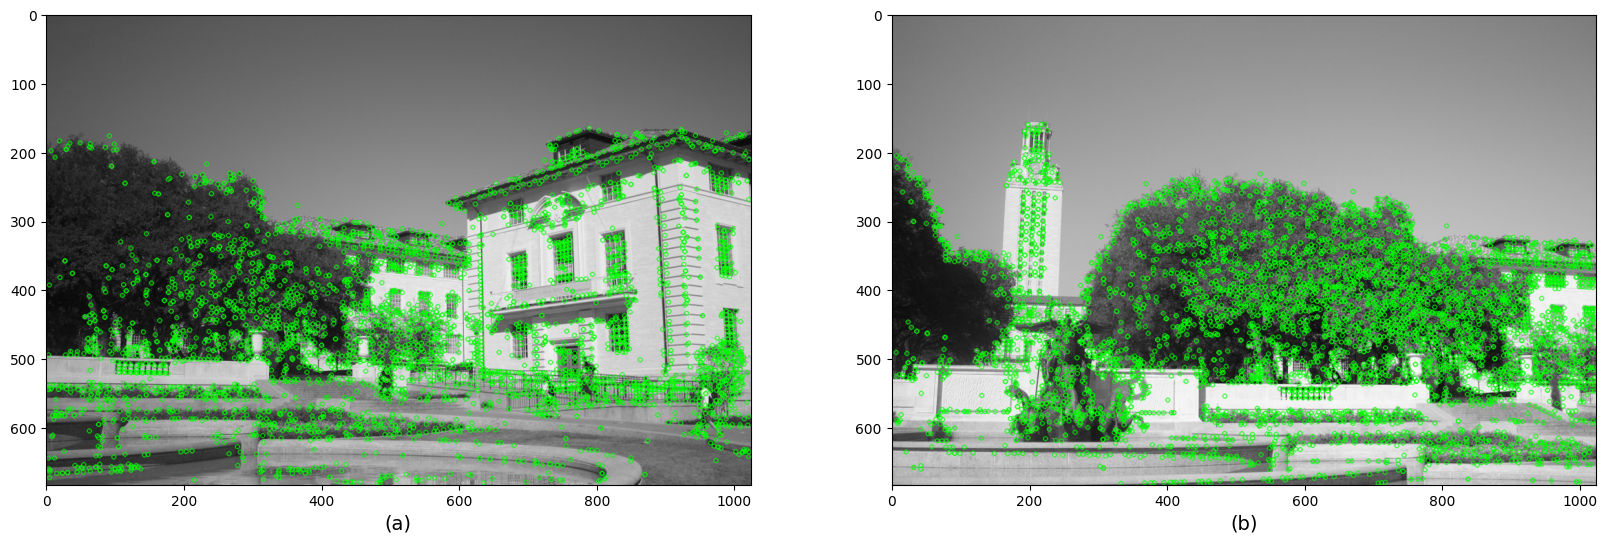

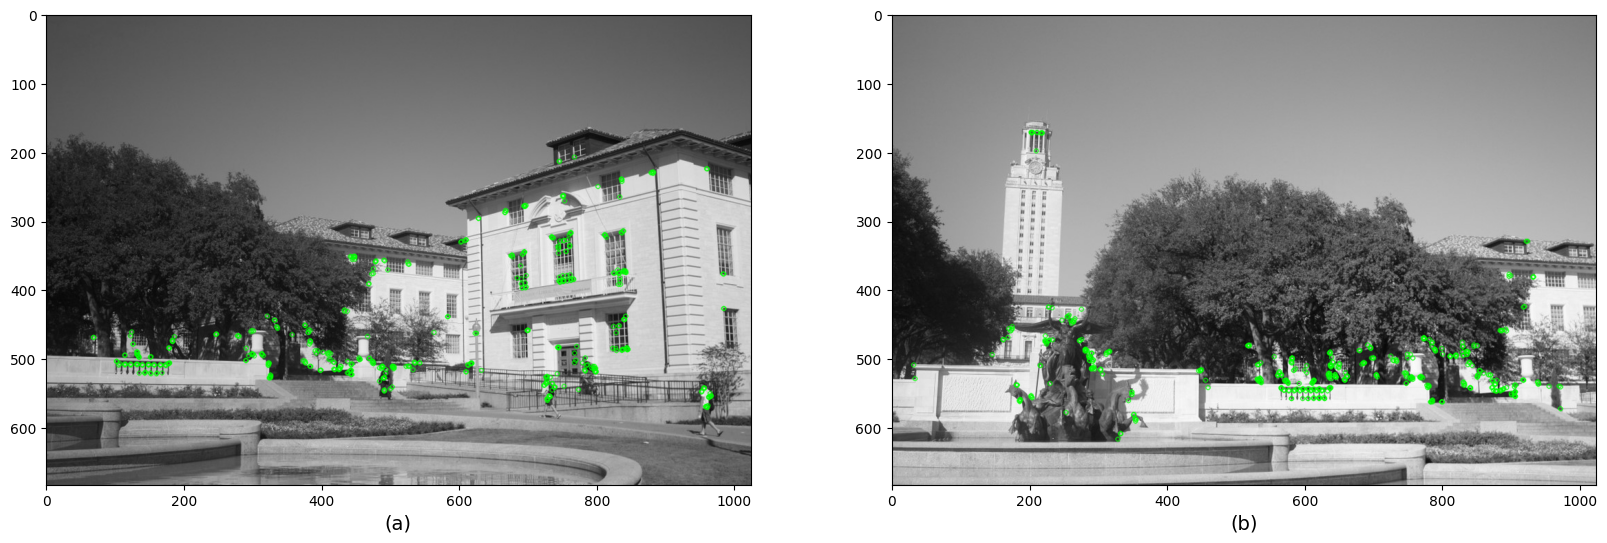

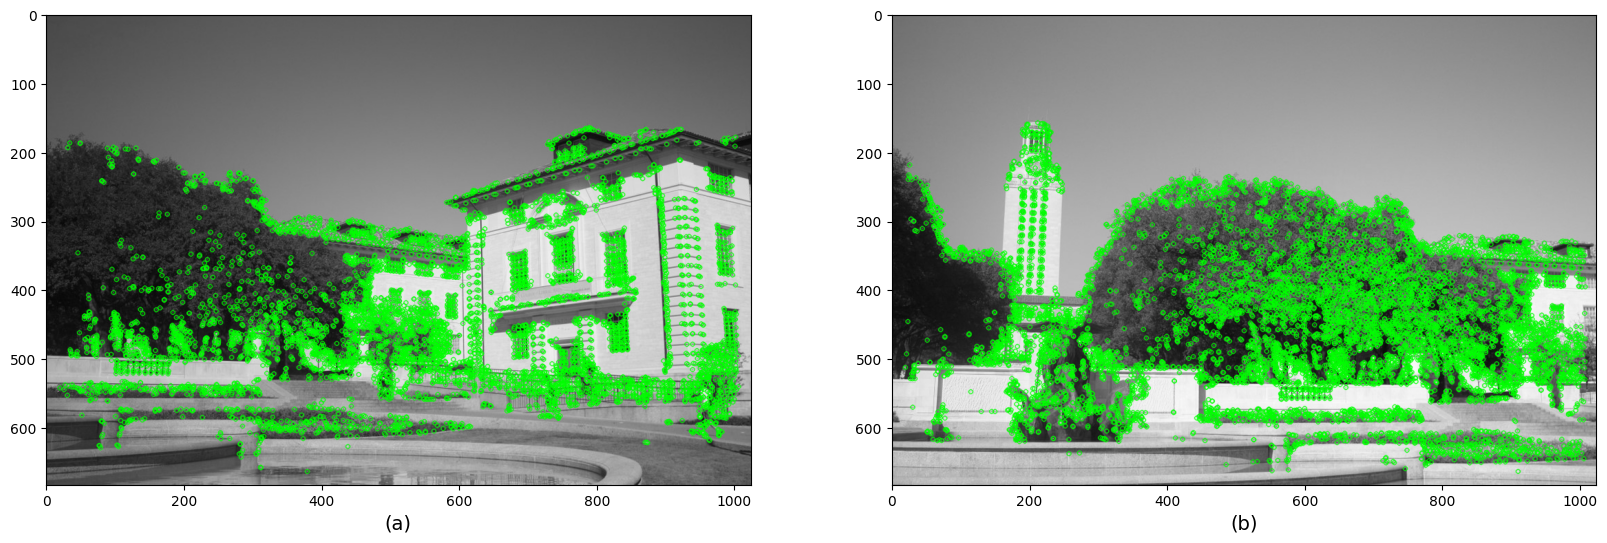

In [23]:
features = ['sift','orb','brisk']
for feature_extractor in features:
  kpsA, features_A = detectAndDescribe(training_image_gray, method=feature_extractor)
  kpsB, features_B = detectAndDescribe(queryImage_gray, method=feature_extractor)
  fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
  ax1.imshow(cv2.drawKeypoints(training_image_gray,kpsA,None,color=(0,255,0)))
  ax1.set_xlabel("(a)", fontsize=14)
  ax2.imshow(cv2.drawKeypoints(queryImage_gray,kpsB,None,color=(0,255,0)))
  ax2.set_xlabel("(b)", fontsize=14)

  plt.show()

Feature Matching

In [24]:
def createMatcher(matching_method,crossCheck):
    "Create and return a Matcher Object"
    
    if matching_method == 'sift' or matching_method == 'surf':
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif matching_method == 'orb' or matching_method == 'brisk':
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return matcher

In [25]:
def matchKeyPointsBF(features_A, features_B, matching_method):
    matcher = createMatcher(matching_method, crossCheck=True)
        
    # Match descriptors.
    best_matches = matcher.match(features_A,features_B)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [26]:
def matchKeyPointsKNN(features_A, features_B, ratio, matching_method):
    matcher = createMatcher(matching_method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = matcher.knnMatch(features_A, features_B, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Homography Estimation

In [27]:
def getHomography(kpsA, kpsB, features_A, features_B, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

Raw matches (knn): 6730
[[ 7.72146868e-01  4.04864270e-02  4.44796365e+02]
 [-1.33694545e-01  9.16609877e-01  7.46339902e+01]
 [-2.07385862e-04 -2.92024438e-05  1.00000000e+00]]


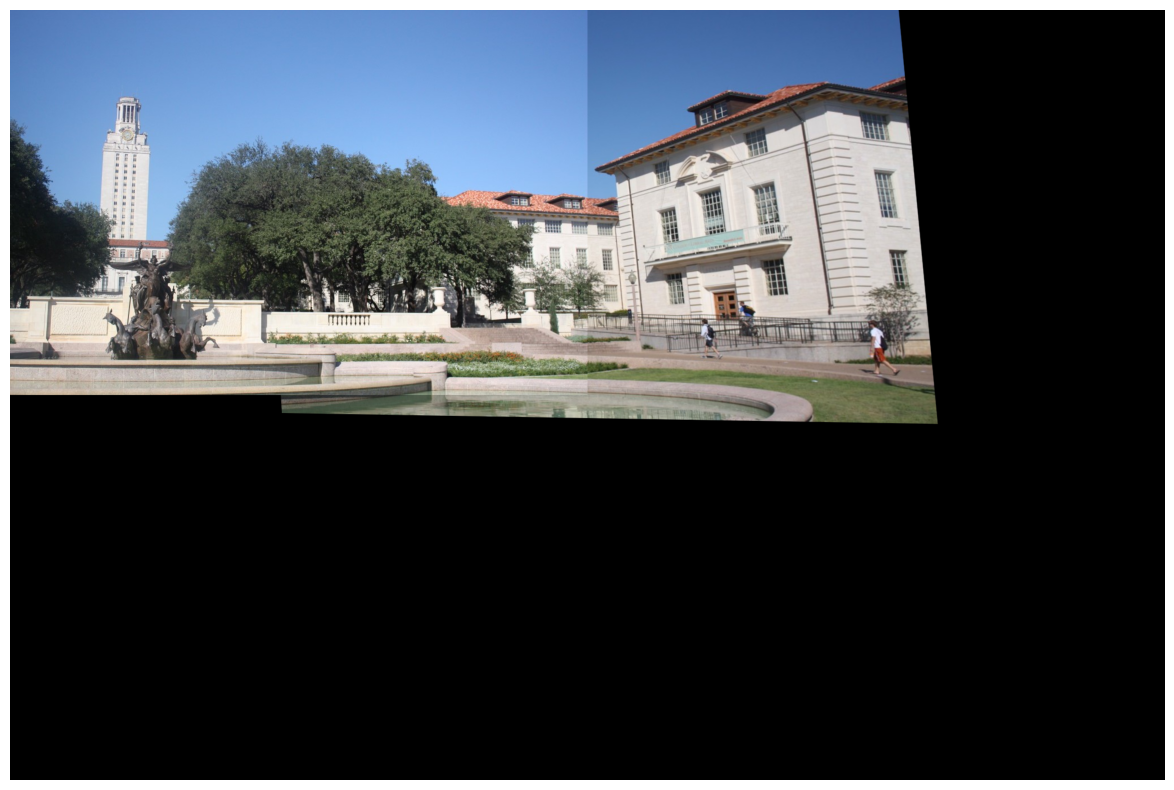

(-0.5, 2047.5, 1365.5, -0.5)

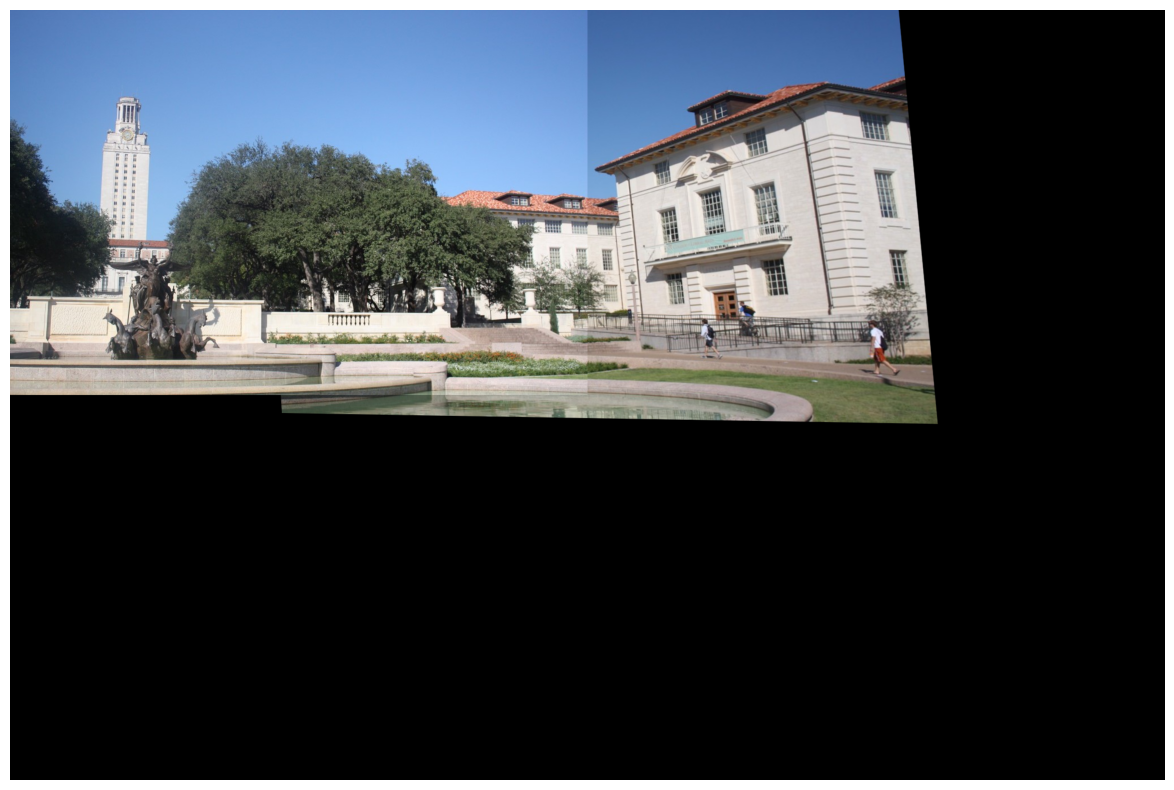

In [29]:
matches = matchKeyPointsKNN(features_A, features_B, ratio=0.8, matching_method='sift')
M = getHomography(kpsA, kpsB, features_A, features_B, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

# Apply panorama correction
width = training_image.shape[1] + queryImage.shape[1]
height = training_image.shape[0] + queryImage.shape[0]

result = cv2.warpPerspective(training_image, H, (width, height))
result[0:queryImage.shape[0], 0:queryImage.shape[1]] = queryImage

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()# Apply panorama correction
width = training_image.shape[1] + queryImage.shape[1]
height = training_image.shape[0] + queryImage.shape[0]

result = cv2.warpPerspective(training_image, H, (width, height))
result[0:queryImage.shape[0], 0:queryImage.shape[1]] = queryImage

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')